This is an Image classification exercise. We will play with an expired Kaggle competition, please follow the rule of Kaggle and check the following page for more information https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/overview. After submit you results, use screenshot to show you score (see image below). They don’t provide ranking for this competition anymore. Thus, no need to show your ranking at Public/Private Leaderboard.

#### Loading Required Libraries

In [25]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Conv1D, Input, MaxPooling1D
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from tensorflow.keras import models
from tensorflow.keras import layers
import pathlib
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

#### Loading and Exploring the Data

In [2]:
cwd = os. getcwd()
cwd
path = '/Users/ngkalok/Desktop/hw4/train/'

In [5]:
files = os.listdir(path)
files[:5]

['dog.8011.jpg',
 'cat.5077.jpg',
 'dog.7322.jpg',
 'cat.2718.jpg',
 'cat.10151.jpg']

In [6]:
len(files)

25000

#### Creating a dataframe with target class : Cats/Dogs

In [18]:
label = []

for jpg in files:
    if jpg.split('.')[0] =='dog':
        label.append('dog')
    else:
        label.append('cat')

In [19]:
df = pd.DataFrame({
    'filename': files,
    'label': label})

In [20]:
df.head()

,filename,label
0,dog.8011.jpg,dog
1,cat.5077.jpg,cat
2,dog.7322.jpg,dog
3,cat.2718.jpg,cat
4,cat.10151.jpg,cat


#### Check the class balance of labels (Dogs and Cats) and see whether the labels are correctly sorted

<AxesSubplot:ylabel='Type'>

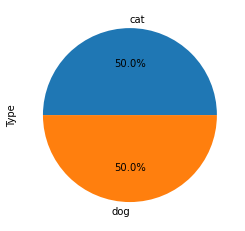

In [26]:
df.groupby('label').size().plot(kind='pie',
                                y = "class",
                                label = "Type",
                                autopct='%1.1f%%')

The dog and cat classes are evenly distributed. Half and half, so we won't have to deal with imbalance class


dog    12500
cat    12500
Name: label, dtype: int64


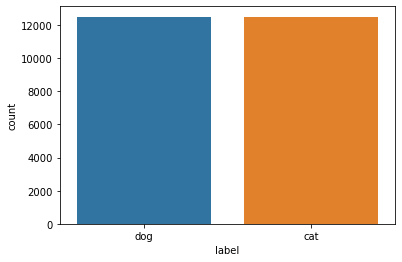

In [27]:
print(df['label'].value_counts())
sns.countplot(data=df, x=df['label']);

#### Let's extract a couple of images from the data

I manually checked the directory and spotted the representable ones in these two classes respectively

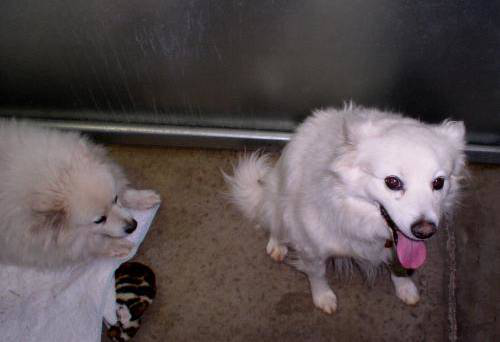

In [32]:
load_img(path+'dog.188.jpg')

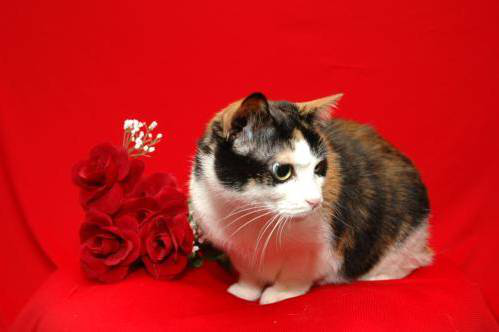

In [33]:
load_img(path+'cat.777.jpg')

#### Preparing Training and Testing DataSets

We are spliting the training and testing data by 8:2, so 20k records will be used for training and 5k records will be used for testing.

In [34]:
train, test = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [35]:
print('Number of training objects:\n',train['label'].value_counts())
print('Number of validation objects:\n',test['label'].value_counts())

Number of training objects:
 dog    10000
cat    10000
Name: label, dtype: int64
Number of validation objects:
 dog    2500
cat    2500
Name: label, dtype: int64


Further, we will scale and generate the data so that it can be fed as an input for our CNN models

In [57]:
train_generator = ImageDataGenerator(rescale=1./255)
train_data = train_generator.flow_from_dataframe(train,
                                                directory = path,
                                                x_col = 'filename',
                                                y_col = 'label',
                                                class_mode = 'binary',
                                                seed = 42,
                                                target_size = (250,250),
                                                batch_size = 64)

Found 20000 validated image filenames belonging to 2 classes.


In [58]:
test_generator = ImageDataGenerator(rescale=1./255)
test_data = test_generator.flow_from_dataframe(test,
                                               directory = path,
                                                x_col = 'filename',
                                                y_col = 'label',
                                                class_mode = 'binary',
                                                seed = 42,
                                                target_size = (250,250),
                                                batch_size = 64)

Found 5000 validated image filenames belonging to 2 classes.


### 1) CNN Model

First, let's make a basic CNN model. In this model, we use 5 consecutive blocks from Conv2D and MaxPooling2d with different filter depths. Since we have a classification task, after 5 blocks we will transform our data into a 1D tensor and apply Dense layers, the last Dense layer should have 1 layer and activation='sigmoid' since we have a binary classification task.

We will set the input of the model to be of size 250x250

In [59]:
# Build a 3 layers of CNN model
# Activation use relu with last activation as sigmoid as this is classification model

cnn1 = models.Sequential()
cnn1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)))
cnn1.add(layers.MaxPooling2D((2, 2)))

cnn1.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn1.add(layers.MaxPooling2D((2, 2)))

cnn1.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn1.add(layers.MaxPooling2D((2, 2)))

cnn1.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn1.add(layers.MaxPooling2D((2, 2)))

cnn1.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn1.add(layers.MaxPooling2D((2, 2)))

cnn1.add(layers.Flatten())
cnn1.add(layers.Dense(512, activation='relu'))
cnn1.add(layers.Dense(1, activation='sigmoid'))

In [60]:
# Checking the architecture of the CNN model

cnn1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 124, 124, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 59, 59, 64)        36928     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 29, 29, 64)      

In [61]:
# Complie the model

cnn1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy', metrics='acc')

Since our submission score is based on loss of crossentropy and this is a binary classification problem, we set loss to 'binary_crossentropy.'

In [62]:
# Fitting the model

hist = cnn1.fit(train_data, validation_data = test_data, epochs = 12)

Epoch 1/12


2022-11-22 11:26:15.594165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 0.6904 - acc: 0.5284

2022-11-22 11:26:50.589909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 43s 133ms/step - loss: 0.6904 - acc: 0.5284 - val_loss: 0.6737 - val_acc: 0.6052
Epoch 2/12
313/313 [==============================] - 42s 134ms/step - loss: 0.6156 - acc: 0.6579 - val_loss: 0.5532 - val_acc: 0.7216
Epoch 3/12
313/313 [==============================] - 41s 131ms/step - loss: 0.4914 - acc: 0.7602 - val_loss: 0.4367 - val_acc: 0.8014
Epoch 4/12
313/313 [==============================] - 42s 134ms/step - loss: 0.4056 - acc: 0.8129 - val_loss: 0.4226 - val_acc: 0.8106
Epoch 5/12
313/313 [==============================] - 42s 134ms/step - loss: 0.3485 - acc: 0.8462 - val_loss: 0.3951 - val_acc: 0.8264
Epoch 6/12
313/313 [==============================] - 41s 131ms/step - loss: 0.3039 - acc: 0.8700 - val_loss: 0.3346 - val_acc: 0.8514
Epoch 7/12
313/313 [==============================] - 41s 130ms/step - loss: 0.2503 - acc: 0.8940 - val_loss: 0.3487 - val_acc: 0.8510
Epoch 8/12
313/313 [==============================] - 40s 127ms/st

#### Basic CNN Model Performance

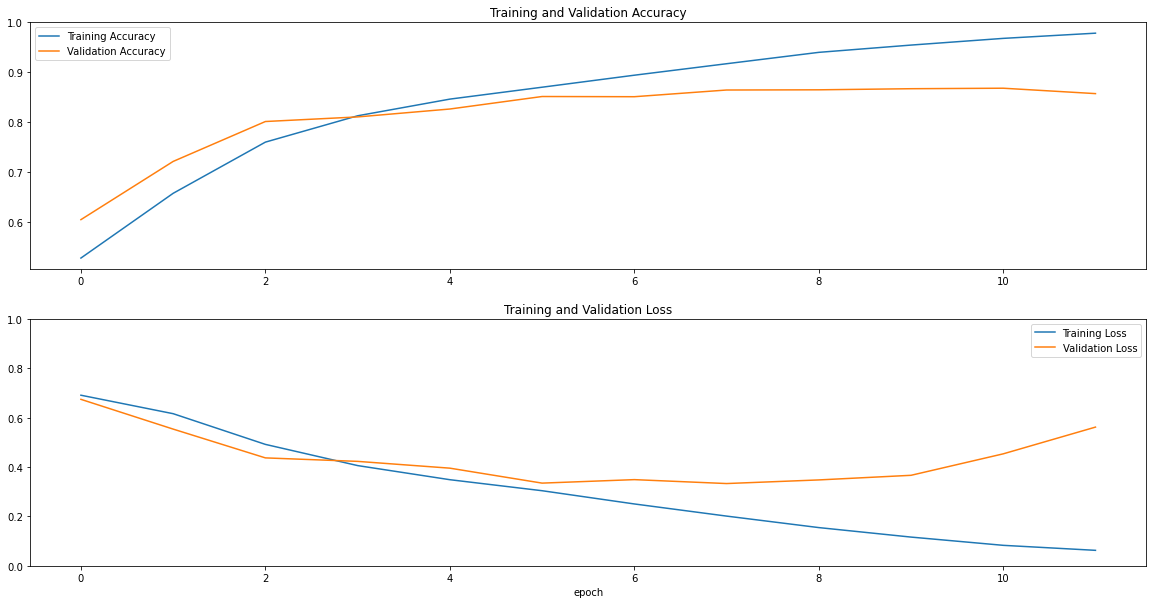

In [68]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

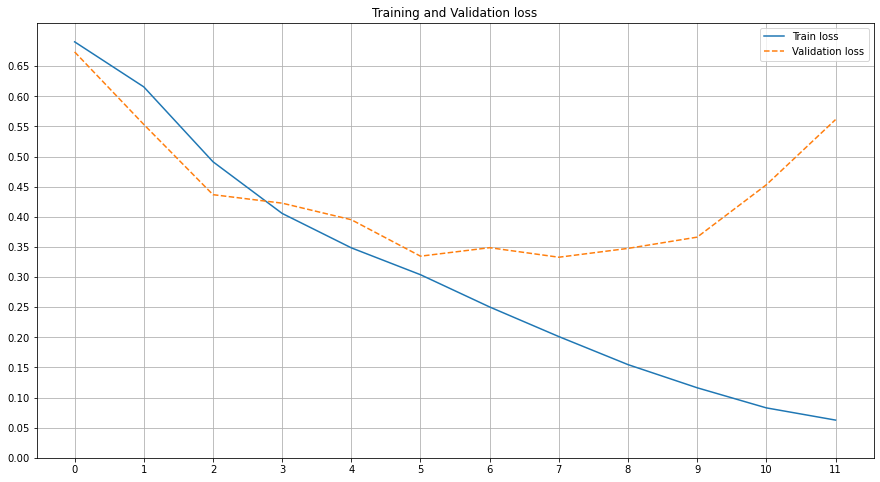

In [69]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(15,8))
plt.plot(loss, label='Train loss')
plt.plot(val_loss,'--', label='Validation loss')
plt.title('Training and Validation loss')
plt.xticks(np.arange(0,12))
plt.yticks(np.arange(0, 0.7, 0.05));
plt.grid()
plt.legend();

From the graphs we can see that the model has the peak performance at 3rd epoch, and start decling after 4th epoch - validation loss doesn't improve much after 3rd or 4th epoch

### 2) Transfer Learning: Xception Model

In [70]:
# Defining base model

base_model = keras.applications.Xception(
    weights="imagenet", #using imagenets weights for better performance
    input_shape=(250, 250, 3),
    include_top=False,
    pooling='avg')

83697664/83683744 [==============================] - 3s 0us/step


In [71]:
# Initially we set training = false because model is good on its own
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 124, 124, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 124, 124, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 31, 31, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 31, 31, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 31, 31, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 31, 31, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 16, 16, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 16, 16, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 16, 16, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 16, 16, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 16, 16, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 16, 16, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 16, 16, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 16, 16, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

In [72]:
# Defining the model

modelx = keras.Sequential()
modelx.add(base_model)
modelx.add(layers.Flatten())
modelx.add(layers.Dense(512, activation='relu'))
modelx.add(layers.Dense(1, activation='sigmoid'))

In [73]:
# Compiling the model

modelx.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics='acc')

We will set the learning rate of the model a little lower as it's default weights perform good enough

In [76]:
# Fitting the model

hist2 = modelx.fit(train_data,
                    validation_data = test_data,
                    epochs = 7,
                    steps_per_epoch=np.ceil(20000/64),
                    validation_steps=np.ceil(5000/64))

Epoch 1/7


2022-11-22 11:38:39.474086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 0.0372 - acc: 0.9878

2022-11-22 11:40:04.903647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 107s 335ms/step - loss: 0.0372 - acc: 0.9878 - val_loss: 0.0416 - val_acc: 0.9866
Epoch 2/7
313/313 [==============================] - 104s 333ms/step - loss: 0.0218 - acc: 0.9930 - val_loss: 0.0367 - val_acc: 0.9894
Epoch 3/7
313/313 [==============================] - 106s 337ms/step - loss: 0.0160 - acc: 0.9946 - val_loss: 0.0349 - val_acc: 0.9886
Epoch 4/7
313/313 [==============================] - 107s 343ms/step - loss: 0.0112 - acc: 0.9964 - val_loss: 0.0373 - val_acc: 0.9890
Epoch 5/7
313/313 [==============================] - 110s 352ms/step - loss: 0.0094 - acc: 0.9969 - val_loss: 0.0388 - val_acc: 0.9898
Epoch 6/7
313/313 [==============================] - 113s 360ms/step - loss: 0.0065 - acc: 0.9978 - val_loss: 0.0450 - val_acc: 0.9884
Epoch 7/7
313/313 [==============================] - 115s 368ms/step - loss: 0.0052 - acc: 0.9985 - val_loss: 0.0444 - val_acc: 0.9878


#### Transfer Learning Model Performance

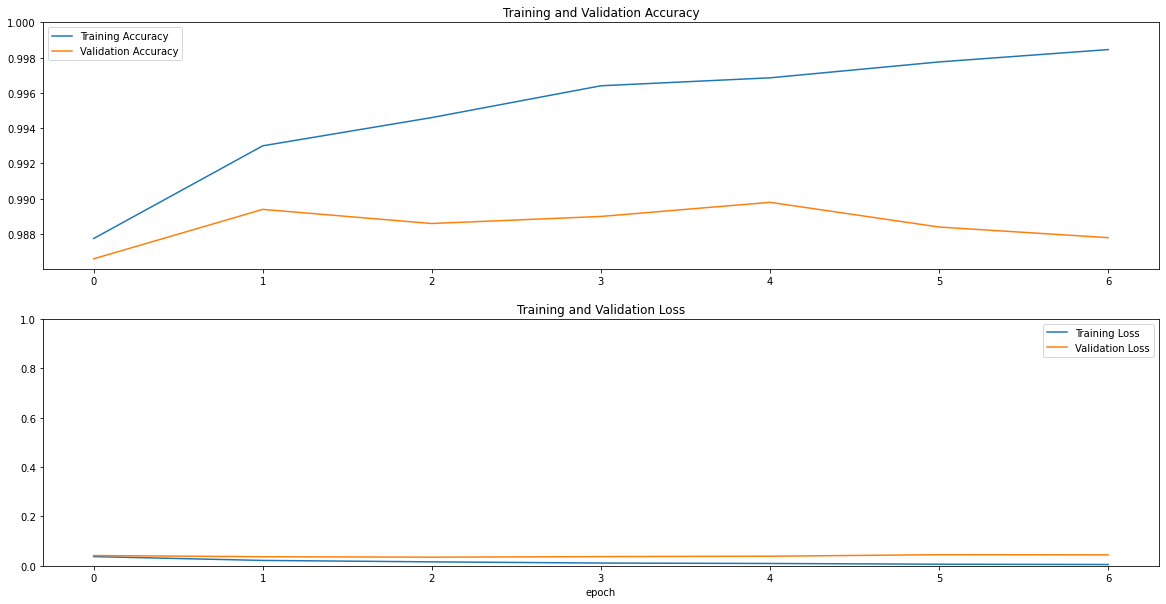

In [80]:
acc = hist2.history['acc']
val_acc = hist2.history['val_acc']

loss = hist2.history['loss']
val_loss = hist2.history['val_loss']

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

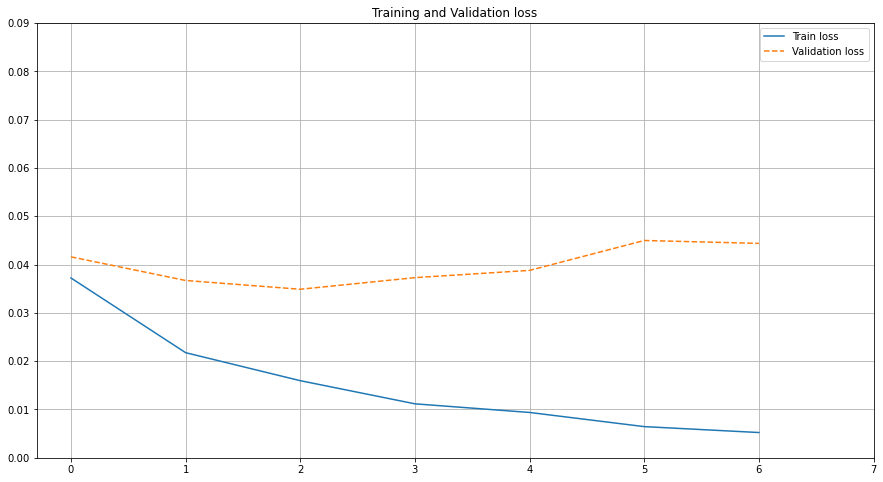

In [81]:
loss = hist2.history['loss']
val_loss = hist2.history['val_loss']

plt.figure(figsize=(15,8))
plt.plot(loss, label='Train loss')
plt.plot(val_loss,'--', label='Validation loss')
plt.title('Training and Validation loss')
plt.xticks(np.arange(0,8))
plt.yticks(np.arange(0, 0.1, 0.01));
plt.grid()
plt.legend();

### 3) Fine Tuning the Xception Model

Now, we'll unfreeze the last 33 layers of the model to make it better for the given dataset

In [82]:
base_model.trainable = True

len(base_model.layers)

133

In [83]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [84]:
# Compiling the new model

modelx.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics='acc')

In [87]:
# Fitting the model

hist3 = modelx.fit(train_data,
                    validation_data = test_data,
                    initial_epoch = 7,
                    epochs = 11,
                    steps_per_epoch=np.ceil(20000/64),
                    validation_steps=np.ceil(5000/64)
                    )

# We will start fitting directly from 7th epoch for 4 more epochs. This should adjust the weights and
# remove any previous bias

Epoch 8/11


2022-11-22 11:56:43.723227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 0.0226 - acc: 0.9920

2022-11-22 11:58:50.110867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 149s 459ms/step - loss: 0.0226 - acc: 0.9920 - val_loss: 0.0331 - val_acc: 0.9906
Epoch 9/11
313/313 [==============================] - 142s 452ms/step - loss: 0.0051 - acc: 0.9984 - val_loss: 0.0372 - val_acc: 0.9886
Epoch 10/11
313/313 [==============================] - 142s 453ms/step - loss: 0.0049 - acc: 0.9980 - val_loss: 0.0383 - val_acc: 0.9898
Epoch 11/11
313/313 [==============================] - 142s 453ms/step - loss: 0.0040 - acc: 0.9986 - val_loss: 0.0502 - val_acc: 0.9890


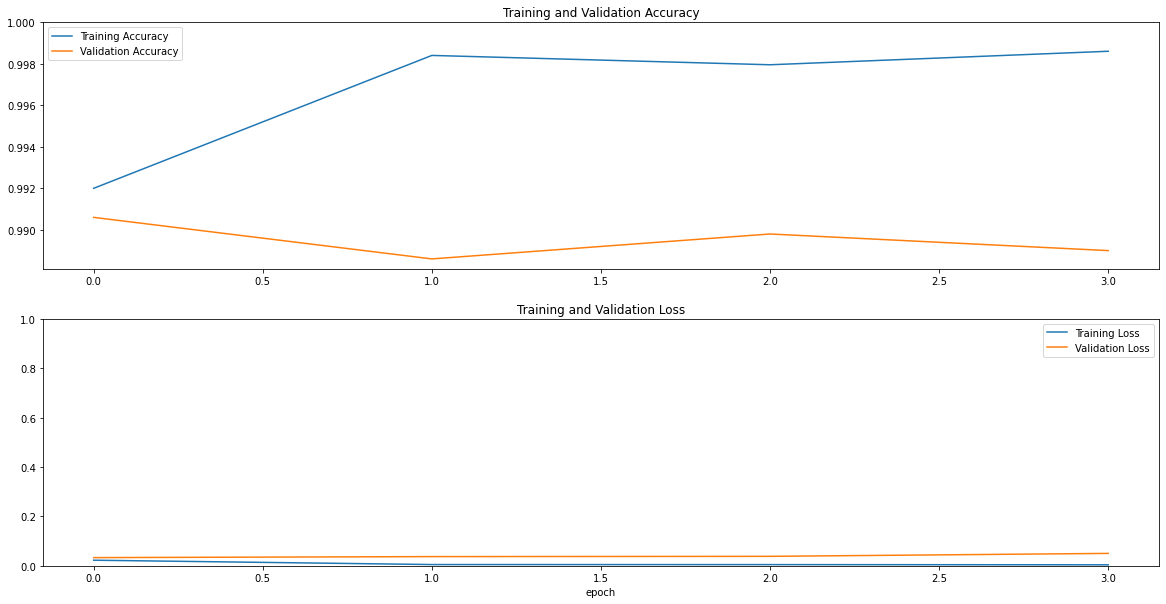

In [91]:
acc = hist3.history['acc']
val_acc = hist3.history['val_acc']

loss = hist3.history['loss']
val_loss = hist3.history['val_loss']

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

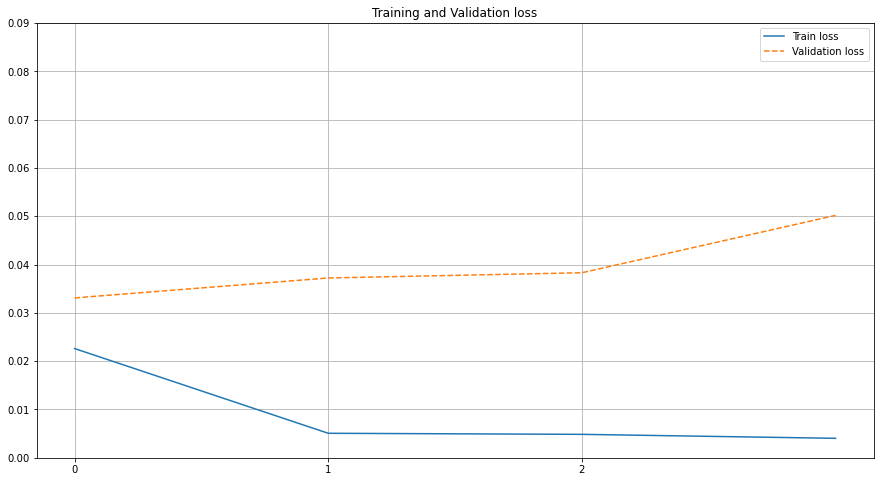

In [88]:
loss = hist3.history['loss']
val_loss = hist3.history['val_loss']

plt.figure(figsize=(15,8))
plt.plot(loss, label='Train loss')
plt.plot(val_loss,'--', label='Validation loss')
plt.title('Training and Validation loss')
plt.xticks(np.arange(0,3))
plt.yticks(np.arange(0, 0.1, 0.01));
plt.grid()
plt.legend();

### Preparing Test Data

In [97]:
path = '/Users/ngkalok/Desktop/hw4/test/'

files2 = os.listdir(path)
files2[:5]

['9733.jpg', '63.jpg', '6400.jpg', '823.jpg', '4217.jpg']

In [98]:
df_test = pd.DataFrame({
            'filename2':files2,
            })

In [99]:
ids = []

for i in files2:
    ids.append(i.split(".")[0])

    
ids[:5]

['9733', '63', '6400', '823', '4217']

In [100]:
test_gen = ImageDataGenerator(rescale=1./255)

test_data = test_gen.flow_from_dataframe(df_test,
                                        directory=path,
                                        x_col='filename2',
                                        y_col= None,
                                        class_mode=None,
                                        seed=42,
                                        target_size=(250,250),
                                        batch_size=64,
                                        shuffle=False)

Found 12500 validated image filenames.


#### Predicting with Transfer Learning Model and Generating the CSV

In [101]:
prediction = modelx.predict(test_data, steps=np.ceil(12500/64))

2022-11-22 12:16:18.573137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [102]:
labels = []

for i in prediction:
    labels.append(i[0])
        
labels[:5]

[5.891434e-05, 2.0661572e-09, 0.9999995, 1.0, 5.283191e-06]

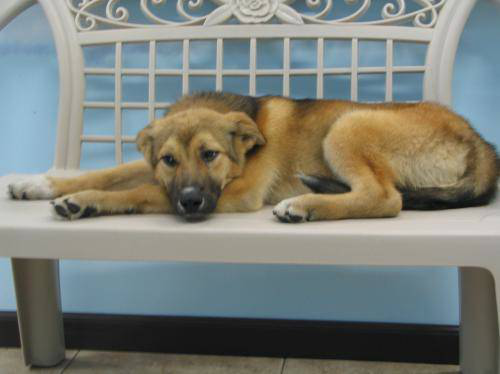

In [109]:
# Checking the prediction manually

load_img(path + files2[514])

In [110]:
# Generating final dataframe and CSV
df_test = pd.DataFrame({
                        'id':ids,
                        'label':labels
                        })

df_test.to_csv("submission.csv", index=False)